# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

**Answer:**
From Data perspective, we need to create a predictive model which takes in all the features of car like model, make, engine, mileage etc. and determine what drives price of the car. We need to use the historical sales data and check the predicted value and compare with the actual value and determine which feature drives the car price. 

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import sys

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

**Load and Inspect the Dataset**

In [42]:
df = pd.read_csv('data/vehicles.csv')
df.tail()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
426875,7301591192,wyoming,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,wy
426876,7301591187,wyoming,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,wy
426877,7301591147,wyoming,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,wy
426878,7301591140,wyoming,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,wy
426879,7301591129,wyoming,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,wy


**Review Data Types**

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [44]:
# Count the NaN values in each column
nan_counts = df.isna().sum()
print("\nNaN counts per column:")
print(nan_counts)


NaN counts per column:
id                   0
region               0
price                0
year              1205
manufacturer     17646
model             5277
condition       174104
cylinders       177678
fuel              3013
odometer          4400
title_status      8242
transmission      2556
VIN             161042
drive           130567
size            306361
type             92858
paint_color     130203
state                0
dtype: int64


### Findings

Following columns should be consider to determine what drives the price of the car.

1. manufacturer
2. model
3. condition
4. fuel
5. odometer
6. type

### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [45]:
# Subset the columns decided to keep
cols = ['price','manufacturer','model','condition','fuel','odometer','type']
df = df[cols].copy()

In [47]:
# Quick sanity checks & remove impossible rows.

# sane filters
df = df[df['price'] > 0]
df = df[df['odometer'].isna() | (df['odometer'] >= 0)]

In [48]:
# Create derived features. Considering log_price = np.log1p(price) for modeling and log_odometer = np.log1p(odometer) if mileage skewed.

df['log_price'] = np.log1p(df['price'])
df['log_odometer'] = np.where(df['odometer'].isna(), np.nan, np.log1p(df['odometer']))

In [49]:
df.isnull().sum()

price                0
manufacturer     16185
model             4701
condition       151389
fuel              2594
odometer          2290
type             85932
log_price            0
log_odometer      2290
dtype: int64

In [104]:
# clean up data
df['fuel'] = df['fuel'].fillna(df['fuel'].mode()[0]) # Small number missing. fill with most common fuel type.
df['odometer'] = df['odometer'].fillna(df['odometer'].median()) # Mileage is heavily skewed → use median imputation.
df['log_odometer'] = np.log1p(df['odometer'])

# set unkown rather than deleting the rows
df['manufacturer'] = df['manufacturer'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')
df['condition'] = df['condition'].fillna('unknown')
df['type'] = df['type'].fillna('unknown')

cond_map = {
    'new':5, 
    'like new':4,
    'excellent':4,
    'good':3,
    'fair':2,
    'salvage':0,
    'unknown':-1
}
df['condition_num'] = df['condition'].map(cond_map)

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [96]:
X = df.drop(columns=['price', 'log_price'])
y = df['log_price']

numeric_features = ['odometer']
categorical_features = ['manufacturer', 'condition', 'fuel', 'type']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [97]:
lin_reg = LinearRegression()

In [98]:
pipe_lr = Pipeline(steps=[('preprocess', preprocess),
                         ('model', lin_reg)])
pipe_lr.fit(X, y)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['odometer']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['manufacturer', 'condition',
                                                   'fuel', 'type'])])),
                ('model', LinearRegression())])

In [99]:
# Linear Regression
lr_preds = pipe_lr.predict(X)
lr_rmse = np.sqrt(mean_squared_error(y, lr_preds))
print("Linear Regression RMSE:", lr_rmse)

Linear Regression RMSE: 1.119332635582748


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Normalized Feature Importance:
base_feature
condition       0.622505
manufacturer    0.349611
type            0.227764
fuel            0.210491
odometer        0.141052
Name: importance_norm, dtype: float64


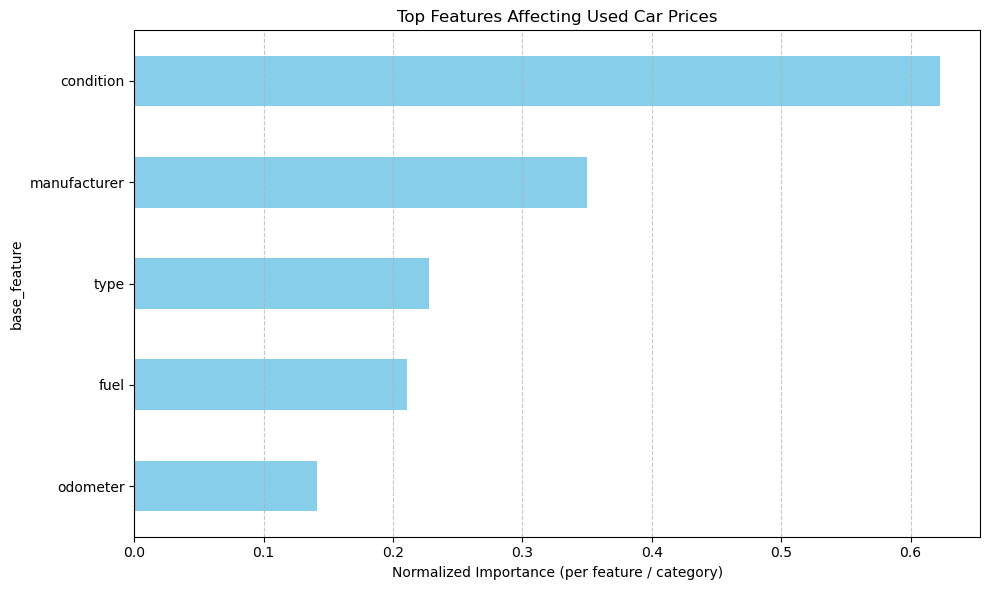

In [105]:
# Extract feature names after preprocessing
preprocessor = pipe_lr.named_steps['preprocess']

# Numeric features (odometer)
num_features = numeric_features

# Categorical features after OneHotEncoding
# Access the OneHotEncoder directly from ColumnTransformer
cat_ohe = preprocessor.named_transformers_['cat']
cat_features = cat_ohe.get_feature_names_out(categorical_features)

# Combine all feature names
all_features = np.concatenate([num_features, cat_features])

# Extract model coefficients
coefs = pipe_lr.named_steps['model'].coef_

# Create DataFrame with coefficients
coef_df = pd.DataFrame({'feature': all_features, 'coef': coefs})
coef_df['abs_coef'] = coef_df['coef'].abs()

# Group one-hot encoded features back to original feature name
coef_df['base_feature'] = coef_df['feature'].apply(lambda x: x.split('_')[0] if '_' in x else x)

# Compute normalized feature importance
# Sum of abs coefficients / number of dummy columns (for categorical features)
coef_df_grouped = coef_df.groupby('base_feature').agg(
    abs_coef_sum=('abs_coef', 'sum'),
    num_dummies=('feature', 'count')
)
coef_df_grouped['importance_norm'] = coef_df_grouped['abs_coef_sum'] / coef_df_grouped['num_dummies']

# Sort by normalized importance
feature_importance = coef_df_grouped['importance_norm'].sort_values(ascending=False)
print("Normalized Feature Importance:")
print(feature_importance)

# Plot top features
top_n = 10
top_features = feature_importance.head(top_n)

plt.figure(figsize=(10,6))
top_features.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Normalized Importance (per feature / category)')
plt.title('Top Features Affecting Used Car Prices')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('images/feature_importance_used_cars.png', dpi=300, bbox_inches='tight')
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

### Report
1. We compared the price with features odometer, manufacturer, condition, fuel, and type
2. We removed model from the ML Model as it had 1000's of different values and it was impacting the model badly.
3. After running the model, we found that condition of the car and manufacturer are the top 2 features which impacts the car prices the most.